In [1]:
import matplotlib.pyplot as plt
from env import DATABASE_URI
from sqlalchemy import create_engine, select, and_
from sqlalchemy.orm import Session, scoped_session, sessionmaker
import models as md
from matplotlib import colormaps

engine = create_engine(DATABASE_URI)

In [12]:
# List runs
with Session(engine) as session:
    run_query = select(md.Run).where(md.Run.mode == "REAL")
    print(session.execute(run_query.order_by(md.Run.id)).scalars().all()[-5:])

[Run(id=36, mode='REAL'), comment='Starting official run of first thermal mockup, heaters on!', Run(id=79, mode='REAL'), comment='Cool down over 3 days. On solder plate that is sideways.', Run(id=84, mode='REAL'), comment='All other heaters on, slowly increase TM + percent decrease power decrease after hitting to 7W', Run(id=85, mode='REAL'), comment='Repeating previous run with constant flow of CO2', Run(id=86, mode='REAL'), comment='Warming up after studies']


In [28]:
# Plot over cooldown


def query_bb(run_id:int, path_id:int, cut_in=0) -> tuple[list, list]:
    with Session(engine) as session:
        bb_data_query = select(md.BbResistancePathData).where(and_(md.BbResistancePathData.run_id == run_id, md.BbResistancePathData.path_id == path_id))
        data = session.execute(bb_data_query).scalars().all()

        t0 = data[cut_in].timestamp
        elapsed_time = lambda t: (t - t0).total_seconds() / (60*60)

        times = [elapsed_time(row.timestamp) for row in data]
        temps = [row.ohms for row in data]
        return times[cut_in:], temps[cut_in:]

def query_sensor(run_id: int, sensor: str, cut_in=0) -> tuple[list, list]:
    with Session(engine) as session:
        query = select(md.Data).where(and_(md.Data.run_id == run_id, md.Data.sensor == sensor))
        data = session.execute(query.order_by(md.Data.id)).scalars().all()

        t0 = data[cut_in].timestamp
        elapsed_time = lambda t: (t - t0).total_seconds() / (60*60) 

        times = [elapsed_time(row.timestamp) for row in data]
        temps = [row.celcius for row in data]
        return times[cut_in:], temps[cut_in:]


run_id = 85
fig, ax_ohms = plt.subplots(figsize=(10,10))

color = 'red'
sens_num = 4
ax_ohms.set_xlabel('time (hours)')
ax_ohms.set_ylabel('Resistance (Ohms)', color=color)
ax_ohms.tick_params(axis='y', labelcolor=color)
ax_ohms.scatter(*query_bb(run_id, sens_num), color=color, s=4, label=str(sens_num))
ax_ohms.set_yticks(range(0,1100,100))
ax_ohms.legend(title="Resistance Path", shadow=True, fontsize=14, title_fontsize=16)
ax_ohms.grid()

ax_T = ax_ohms.twinx()  # instantiate a second Axes that shares the same x-axis

ax_T.set_ylabel('Temperature (Celcius)', color="blue")
ax_T.tick_params(axis='y', labelcolor="blue")
ax_T.plot(*query_sensor(run_id, f"L{sens_num}"), color="blue", linestyle="solid", label=f"L{sens_num}")
ax_T.plot(*query_sensor(run_id, f"E{sens_num}"), color="mediumblue", linestyle="solid", label=f"E{sens_num}")
ax_T.set_ylim(-35, 20)  # Set the y-axis range for temperature

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax_T.legend(title="Temperature", loc='center right', shadow=True, fontsize=14, title_fontsize=16)

plt.title(f"BB Health Over Time: Position {sens_num}")

plt.close()

In [ ]:
## Bringing in the CO2 information

import pandas as pd
# Year/Month/Day Hour:Minute:Second.Millisecond
df_co2 = pd.read_csv("./CO2 temperature.csv", usecols=range(3), parse_dates=['Time'])
df_co2.ffill(inplace=True)
df_co2['Time'] = pd.to_datetime(df_co2['Time'])  # Ensure 'Time' is in datetime format
df_co2['Time'] = df_co2['Time'].dt.tz_localize('Europe/Zurich')  # Localize to Geneva timezone
df_co2.sort_values('Time', inplace=True)  # Ensure df_co2 is sorted

run_id = 85
sensors = ["L1", "L2", "L3", "L4", "E1", "E2", "E3", "E4", "P1", "P2", "P3"]
with Session(engine) as session:
    tm_data = {}
    for sensor in sensors:
        query = select(md.Data).where(and_(md.Data.run_id == run_id, md.Data.sensor == sensor))
        data = session.execute(query.order_by(md.Data.id)).scalars().all()

        sensor_data = {}
        sensor_data[f"{sensor}_Temperature"] = [row.celcius for row in data]
        sensor_data[f"{sensor}_Time"]        = [row.timestamp for row in data]

        tm_data[sensor] = pd.DataFrame(sensor_data)

df = df_co2.copy()
for sensor, sensor_df in tm_data.items():
    sensor_df.sort_values(f"{sensor}_Time", inplace=True)
    sensor_df[f"{sensor}_Time"] = sensor_df[f"{sensor}_Time"].dt.tz_convert('Europe/Zurich')

    df = pd.merge_asof(
        df,
        sensor_df,
        left_on='Time',
        right_on=f"{sensor}_Time",
        direction='nearest',
        tolerance = pd.Timedelta('30s')
    )
    del df[f"{sensor}_Time"]


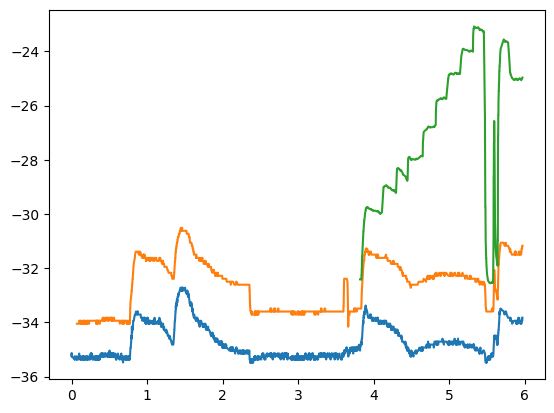

In [ ]:
df
df['Elapsed'] = (df['Time'] - df["Time"].iloc[0]).dt.total_seconds() / (60*60)
plt.plot(df['Elapsed'], df['CO2_Temperature_Outlet'], label='Outlet Temperature')
plt.plot(df['Elapsed'], df['CO2_Temperature_Inlet'] , label='Inlet Temperature')
plt.plot(df['Elapsed'], df['L1_Temperature'] , label='Inlet Temperature')


df_cut = df[df['Elapsed'] > 4]
plt.plot(df["Elapsed"], df["L1_Temperature"]-df["CO2_Temperature_Outlet"])